In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from tensorflow.python.framework import ops
from utils import *
import json
from datetime import datetime

## Replicating CNN from Noda Paper

https://opg.optica.org/oe/fulltext.cfm?uri=oe-26-25-32704&id=402684

Their model is very simple:
### Layers:
    2D convolutional layer, kernel size (3x5), stride (1x2), 50 filters
    Dense layer with 500 units, ReLU activation
    Dropout layer
    Dense layer with 50 units, ReLU activation
    Dense layer with 1 units, ReLU activaiton

In [2]:
data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat"
mechFreq, optFreq, mechQ, optQ, paramsMat = load_data(data_path)

paramsShape = np.shape(paramsMat)[:-1]
num_examples = np.shape(paramsMat)[-1]
optQ_linearized = np.log10(optQ)

paramsMat_transposed = tf.transpose(paramsMat, perm = [3, 0, 1, 2])
print("shape of paramsMat_transposed: \t", np.shape(paramsMat_transposed))

print("shape of optQ: \t", np.shape(optQ))

print("number of training examples: \t", num_examples)

Loading data from:  Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat 

shape of paramsMat_transposed: 	 (911, 11, 18, 3)
shape of optQ: 	 (911, 1)
number of training examples: 	 911


Text(0, 0.5, 'occurences in data set')

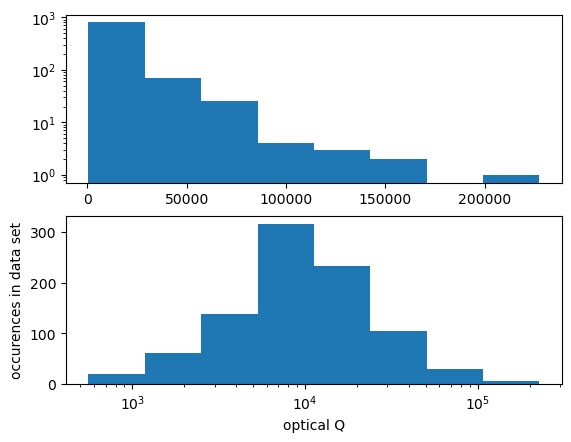

In [8]:
# looking at the data a bit:

x = optQ
# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=8)
plt.yscale('log')

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.xlabel("optical Q")
plt.ylabel('occurences in data set')

Split the data into train and test sets using tensorflow. Because optical Q is generally sampled logrithmically, to train with a linear activation in the last layer we should take the log of the optical Q data before giving it to the model.

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((paramsMat_transposed, optQ_linearized))

# Shuffle and split the dataset
train_size = int(0.8 * num_examples)
train_dataset = dataset.shuffle(buffer_size=num_examples).take(train_size)
test_dataset = dataset.skip(train_size)

# Example of batching the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Define the model

In [10]:
# define the model using the functional API structure rather than teh sequential structure in order to make it more flexible in the future.

def Noda_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> FLATTEN -> DENSE 200 -> RELU -> DROPOUT -> DENSE 50 -> RELU -> DENSE 1

    Arguments:
    input_img -- input dataset, of shape (input_shape)
    kernel_size -- list of kernel sizes for each Conv2D step
    pool_size -- list of pool sizes for each MaxPool2D step

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tfl.Conv2D(filters = 50, kernel_size = (5, 3), strides = (2, 1), padding = 'same')(input_img)
    A1 = tfl.ReLU()(Z1)
    F = tfl.Flatten()(A1)

    A2 = tfl.Dense(200, activation = 'relu')(F)
    D = tfl.Dropout(rate = 0.01)(A2)
    A3 = tfl.Dense(50, activation = 'relu')(D)

    output = tfl.Dense(1)(A3)
    
    model = tf.keras.Model(inputs=input_img, outputs=output)
    return model

In [11]:
conv_model = Noda_model(paramsShape)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
conv_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

conv_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 18, 50)           │           2,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 6, 18, 50)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 200)                 │       1,080,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,092,601 (4.17 MB)

 Trainable params: 1,092,601 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.0182 - mse: 9.0182 - val_loss: 0.4201 - val_mse: 0.4201
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3916 - mse: 0.3916 - val_loss: 0.1833 - val_mse: 0.1833
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2195 - mse: 0.2195 - val_loss: 0.2095 - val_mse: 0.2095
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1921 - mse: 0.1921 - val_loss: 0.2129 - val_mse: 0.2129
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1978 - mse: 0.1978 - val_loss: 0.1830 - val_mse: 0.1830
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2277 - mse: 0.2277 - val_loss: 0.2890 - val_mse: 0.2890
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2423 - mse: 0.2423 - val_loss: 0.2107 - val_mse: 0.2107
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2096 - mse: 0.2096 - val_loss: 0.2174 - val_mse: 0.2174
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.19

In [13]:
conv_model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266 - mse: 0.0266


[0.027470078319311142, 0.027470078319311142]

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_26540\4191875033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

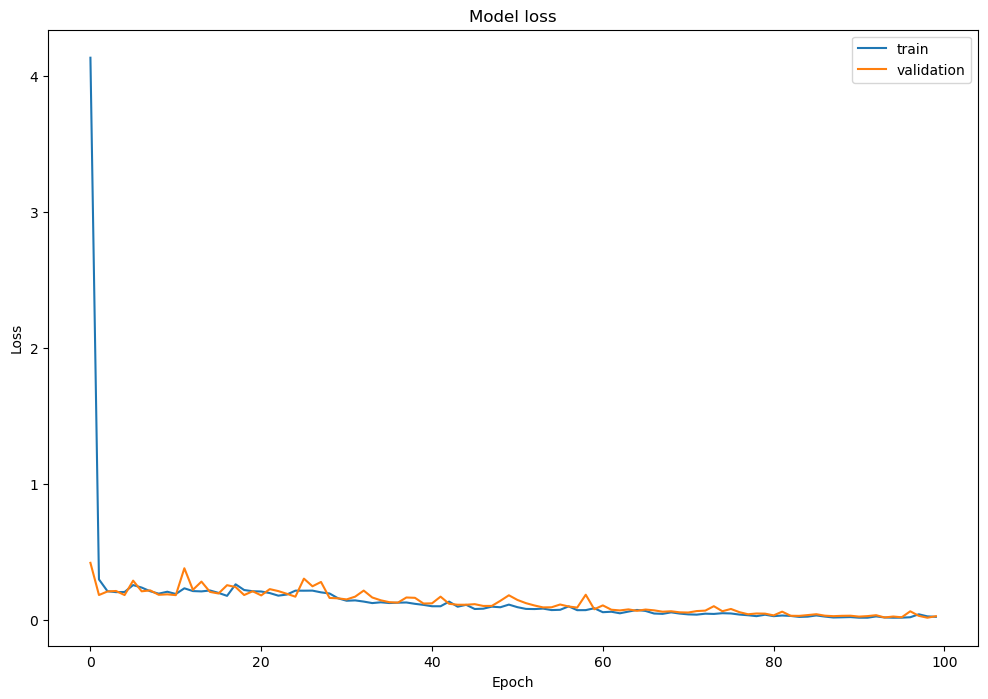

In [14]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
# df_mse= df_loss_acc[['mse','val_mse']]
# df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
# df_mse.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='MSE')

With a trained model in hand it might be nice to see individual examples of how good it is at predicting...

In [15]:
example_numbers = np.arange(10)
batch_number = 1
predicted, true = show_predicted_Qs(example_numbers, batch_number, test_dataset, conv_model)

predicted Q = 9937.600902921495
true Q = 18979.77548521513

predicted Q = 38112.21802548818
true Q = 49243.36569777605

predicted Q = 7861.0168183485775
true Q = 7866.390805749998

predicted Q = 14437.532321987595
true Q = 9167.073822399114

predicted Q = 7387.108595483378
true Q = 8730.271376179075

predicted Q = 3442.6388102343467
true Q = 5796.2399871982525

predicted Q = 4138.125389351302
true Q = 5382.768527921751

predicted Q = 2324.1484617267665
true Q = 1183.7731801948214

predicted Q = 14495.12553950445
true Q = 21780.79818099506

predicted Q = 1171.325034253838
true Q = 1138.5786945380885



Noda model is fine but not amazing.  I think adding dropout is a nice feature.